# Traffic data

## 1. Data description

Alerts created from users on the Waze app to notify accidents, roadwork, traffic changes from the city of Rio de Janeiro. 
The collected information are:

- Identification of the alert.
- Date of the alert with hour and minutes.
- Position in longitude x latitude.
- Type of the alert.
- Comment explaining the alert.
- Number of likes, reliability and confidence of the alert.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from shapely.geometry import Polygon
from matplotlib import cm
import sys
import os
module_path = os.path.abspath(os.path.join('../scripts'))
sys.path.append(module_path)

from stdbscan import *
from coordinates import *

plt.style.use("ggplot")

## 2. Data preprocessing

There are many rows of data from the same alert, each with different timestamps, the first step is to join the big data and groupby by the alert identification.

After that it is necessery to project the coordinates to the UTM system, because when applying the clustering method ST-DBSCAN, we desire to compute euclidean distance between points, and the UTM system have distances that are closer to a distance in a plane.



### 2.1 Frebuary of 2019

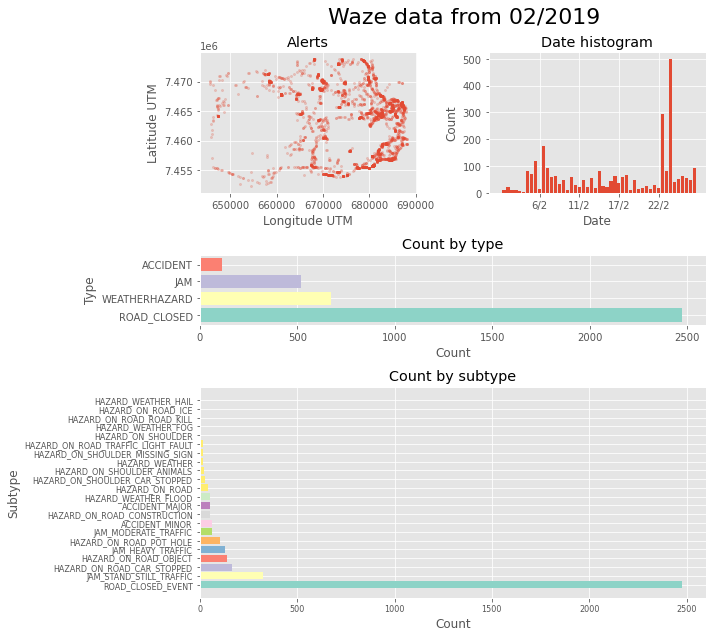

In [2]:
df = pd.read_csv("../data/waze/waze-01022019-28022019.csv")
df = df[~df.comments.isna()]
fig = plt.figure(constrained_layout=True, figsize = (10, 9))
gs = fig.add_gridspec(3, 2, height_ratios = [2, 1, 3])

#MAP PLOT
f_ax1 = fig.add_subplot(gs[0, 0])
f_ax1.scatter(df.longitude_utm, df.latitude_utm, s = 5, alpha = 0.25, rasterized = True)
f_ax1.set_xlabel("Longitude UTM")
f_ax1.set_ylabel("Latitude UTM")
f_ax1.set_title("Alerts")

#TIME HISTOGRAM
start_time = df.start_time.min()
end_time = df.end_time.max()
range_time = end_time - start_time
bin_size = range_time/50
counts = np.ones(50)
xticks = []
xtick_labels = []
for i in range(1, 50):
    x0 = start_time + (i - 1) * bin_size 
    x1 = start_time + i * bin_size 
    if i%10 == 0:
        xtick_labels.append(str(pd.to_datetime(x0, origin = 'unix', unit = 's').day) + 
                            "/" +
                            str(pd.to_datetime(x0, origin = 'unix', unit = 's').month))
    counts[i] = df[((df.start_time >= x0) & (df.end_time < x1))].shape[0]
    

f_ax2 = fig.add_subplot(gs[0, 1])
f_ax2.bar(list(range(0, 50)), counts)
f_ax2.set_title("Date histogram")
f_ax2.set_xlabel("Date")
f_ax2.set_ylabel("Count")
f_ax2.set_xticks([i*10 for i in range(1, 5)])
f_ax2.set_xticklabels(xtick_labels)

#TYPE COUNT
f_ax3 = fig.add_subplot(gs[1, :])
f_ax3.set_title('gs[1, :]')
temp = pd.DataFrame(df.type.value_counts())
types = []
for i in range(temp.shape[0]):
    types.append({"type": temp.index[i],
                    "color": cm.Set3(i),
                    "count": temp.type.iloc[i]})
f_ax3.barh(list(range(len(types))), [x['count'] for x in types], color = [x['color'] for x in types])
f_ax3.set_yticks(list(range(len(types))))
f_ax3.set_yticklabels([x['type'] for x in types])
f_ax3.set_title("Count by type")
f_ax3.set_ylabel("Type")
f_ax3.set_xlabel("Count")

#SUBTYPE COUNT
f_ax4 = fig.add_subplot(gs[2, :])
f_ax4.set_title('gs[2:, :]')
f_ax4.tick_params(axis='both', which='major', labelsize=8)
#f_ax4.tick_params(axis='both', which='minor', labelsize=6)
temp = pd.DataFrame(df.subtype.value_counts())
subtypes = []
for i in range(temp.shape[0]):
    subtypes.append({"subtype": temp.index[i],
                    "color": cm.Set3(i),
                    "count": temp.subtype.iloc[i]})

f_ax4.barh(list(range(len(subtypes))), [x['count'] for x in subtypes], color = [x['color'] for x in subtypes])
f_ax4.set_yticks(list(range(len(subtypes))))
f_ax4.set_yticklabels([x['subtype'] for x in subtypes])
f_ax4.set_title("Count by subtype")
f_ax4.set_ylabel("Subtype")
f_ax4.set_xlabel("Count")        
plt.suptitle("Waze data from 02/2019", x = 0.65, fontsize = 22)
plt.tight_layout()
plt.savefig('figs/waze-february.pdf')
plt.show()

Preprocessing 3775 alerts
spatial threshold: 700
temporal threshold: 14400
min neighbors 10
Fraction of noise points: 0.486
Total of events: 56


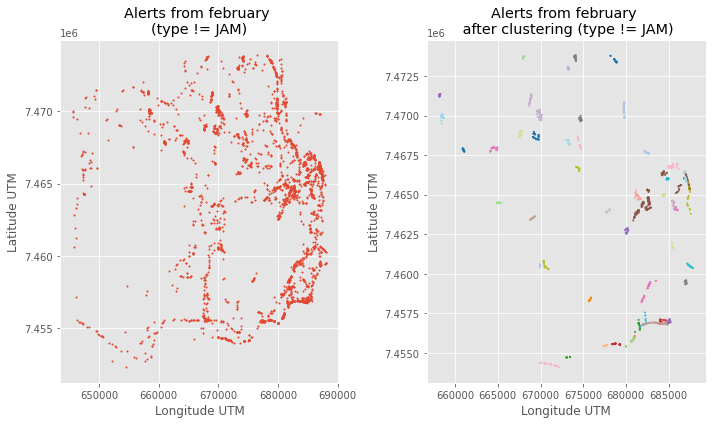

In [3]:
df = pd.read_csv("../data/waze/waze-01022019-28022019.csv")
df = df[~df.comments.isna()]
print(f"Preprocessing {df.shape[0]} alerts")

fig = plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.scatter(df.longitude_utm, df.latitude_utm, s = 2)
plt.xlabel("Longitude UTM")
plt.ylabel("Latitude UTM")
plt.title("Alerts from february \n(type != JAM)")

spatial_threshold = 700
temporal_threshold = 3600*4
min_neighbors = 10
print('spatial threshold:', spatial_threshold)
print("temporal threshold:", temporal_threshold)
print("min neighbors", min_neighbors)
m = STDBSCAN(spatial_threshold, temporal_threshold, min_neighbors)
df['event'] = m.fit_transform(df, 
                              col_x = 'longitude_utm', 
                              col_y = 'latitude_utm', 
                              col_start_time = 'start_time',
                              col_end_time = 'end_time',
                              col_subtype = 'subtype'
                            )

print(f"Fraction of noise points: {(df.event == -1).sum()/df.shape[0]:.3f}")
df = df[df.event != -1]
print(f"Total of events: {len(df.event.unique())}")

plt.subplot(122)
plt.scatter(df.longitude_utm, df.latitude_utm, c = df.event, cmap = "tab20", s = 2)
plt.xlabel("Longitude UTM")
plt.ylabel("Latitude UTM")
plt.title("Alerts from february \n after clustering (type != JAM)")
plt.tight_layout()
plt.show()

In [4]:
df_points = df.copy()
df_points = df_points[((df_points.start_date >= "2019-02-01") & ((df_points.end_date < "2019-03-01")))]
df_points.rename(columns = {"longitude_utm": "xcenter", "latitude_utm": "ycenter"}, inplace = True)
df_points['start_time'] = df_points['start_time'] * 1000
df_points['end_time'] = df_points['end_time'] * 1000
df_points.to_csv("../app/static/data/traffic_february_comments_points.csv", index = False)

agg_dict = {"xcenter": "mean", "ycenter": "mean", 
            "uuid": "count", 
            "type": pd.Series.mode, 
            "start_time" : "min",
            "end_time" : "max"}
df_events = df_points.groupby("event").agg(agg_dict).reset_index()
df_events.columns = ['event', 'xcenter', 'ycenter', 'total_points', 'type', 'start_time', 'end_time']

#Calculating area of events
df_events['area'] = 0
for event in df_events.event:
    df_filtered_event = df_points[df_points.event == event]
    if df_filtered_event.shape[0]> 3:
        coords = df_filtered_event[['xcenter', 'ycenter']].values
        area = Polygon(coords).convex_hull.area
        df_events.loc[df_events.event == event, 'area'] = area
        
df_events['duration'] = (df_events.end_time - df_events.start_time)/3600
df_events.to_csv("../app/static/data/traffic_february_comments_events.csv", index = False)

### 2.2 December of 2018 to February of 2019

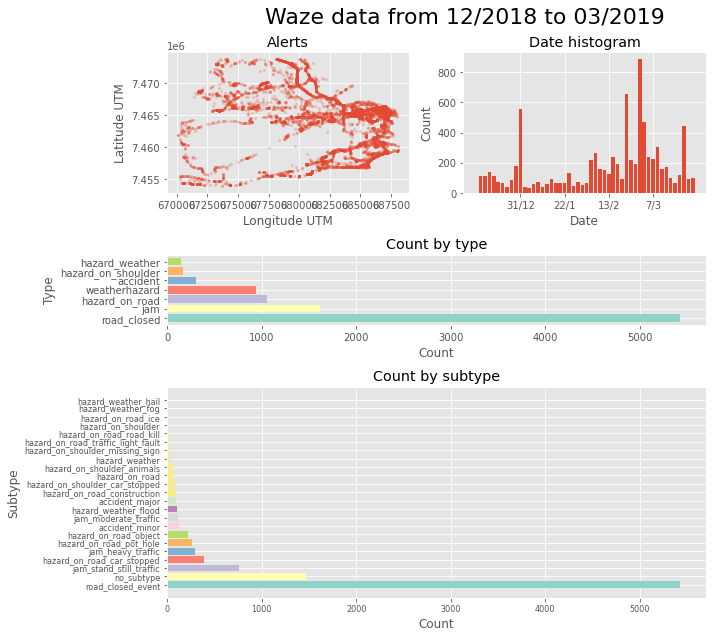

In [5]:
df = pd.read_csv("../data/waze/rj_alerts_11-18_03-19.csv")
df = convert_to_utm(df, src_epsg=4326, dst_epsg=32723, 
                    col_lat='latitude', col_lon='longitude', 
                    alias_lat='latitude_utm',alias_lon='longitude_utm')
df["start_date"] = pd.to_datetime(df.start_date)
df["end_date"] = pd.to_datetime(df.end_date)
df['start_time'] = df.start_date.apply(lambda x : x.timestamp())
df['end_time'] = df.end_date.apply(lambda x : x.timestamp())
fig = plt.figure(constrained_layout=True, figsize = (10, 9))
gs = fig.add_gridspec(3, 2, height_ratios = [2, 1, 3])

#MAP PLOT
f_ax1 = fig.add_subplot(gs[0, 0])
f_ax1.scatter(df.longitude_utm, df.latitude_utm, s = 5, alpha = 0.25, rasterized = True)
f_ax1.set_xlabel("Longitude UTM")
f_ax1.set_ylabel("Latitude UTM")
f_ax1.set_title("Alerts")

#TIME HISTOGRAM
start_time = df.start_time.min()
end_time = df.end_time.max()
range_time = end_time - start_time
bin_size = range_time/50
counts = np.ones(50)
xticks = []
xtick_labels = []
for i in range(1, 50):
    x0 = start_time + (i - 1) * bin_size 
    x1 = start_time + i * bin_size 
    if i%10 == 0:
        xtick_labels.append(str(pd.to_datetime(x0, origin = 'unix', unit = 's').day) + 
                            "/" +
                            str(pd.to_datetime(x0, origin = 'unix', unit = 's').month))
    counts[i] = df[((df.start_time >= x0) & (df.end_time < x1))].shape[0]
    

f_ax2 = fig.add_subplot(gs[0, 1])
f_ax2.bar(list(range(0, 50)), counts)
f_ax2.set_title("Date histogram")
f_ax2.set_xlabel("Date")
f_ax2.set_ylabel("Count")
f_ax2.set_xticks([i*10 for i in range(1, 5)])
f_ax2.set_xticklabels(xtick_labels)

#TYPE COUNT
f_ax3 = fig.add_subplot(gs[1, :])
f_ax3.set_title('gs[1, :]')
temp = pd.DataFrame(df.type.value_counts())
types = []
for i in range(temp.shape[0]):
    types.append({"type": temp.index[i],
                    "color": cm.Set3(i),
                    "count": temp.type.iloc[i]})
f_ax3.barh(list(range(len(types))), [x['count'] for x in types], color = [x['color'] for x in types])
f_ax3.set_yticks(list(range(len(types))))
f_ax3.set_yticklabels([x['type'] for x in types])
f_ax3.set_title("Count by type")
f_ax3.set_ylabel("Type")
f_ax3.set_xlabel("Count")

#SUBTYPE COUNT
f_ax4 = fig.add_subplot(gs[2, :])
f_ax4.set_title('gs[2:, :]')
f_ax4.tick_params(axis='both', which='major', labelsize=8)
#f_ax4.tick_params(axis='both', which='minor', labelsize=6)
temp = pd.DataFrame(df.subtype.value_counts())
subtypes = []
for i in range(temp.shape[0]):
    subtypes.append({"subtype": temp.index[i],
                    "color": cm.Set3(i),
                    "count": temp.subtype.iloc[i]})

f_ax4.barh(list(range(len(subtypes))), [x['count'] for x in subtypes], color = [x['color'] for x in subtypes])
f_ax4.set_yticks(list(range(len(subtypes))))
f_ax4.set_yticklabels([x['subtype'] for x in subtypes])
f_ax4.set_title("Count by subtype")
f_ax4.set_ylabel("Subtype")
f_ax4.set_xlabel("Count")        
plt.suptitle("Waze data from 12/2018 to 03/2019", x = 0.65, fontsize = 22)
plt.tight_layout()
plt.savefig('figs/waze-four-months.pdf')
plt.show()

Preprocessing 9594 alerts
spatial threshold: 500
temporal threshold: 10800
min neighbors 5
Fraction of noise points: 0.457
Total of events: 166


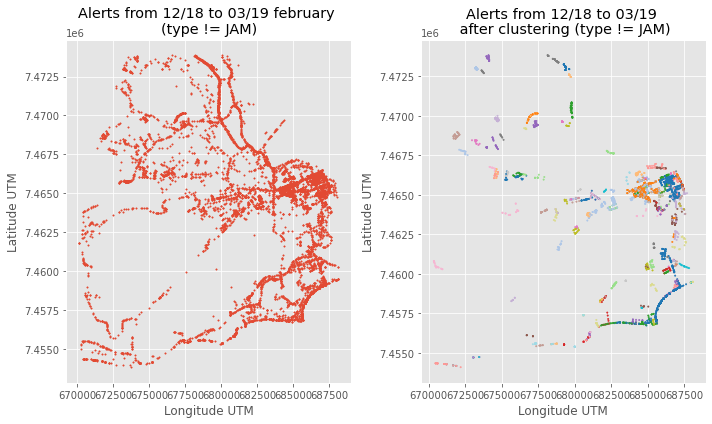

In [6]:
df = pd.read_csv("../data/waze/rj_alerts_11-18_03-19.csv")
df = df.dropna()
df = convert_to_utm(df, src_epsg=4326, dst_epsg=32723, 
                    col_lat='latitude', col_lon='longitude', 
                    alias_lat='latitude_utm',alias_lon='longitude_utm')
df["start_date"] = pd.to_datetime(df.start_date)
df["end_date"] = pd.to_datetime(df.end_date)
df['start_time'] = df.start_date.apply(lambda x : x.timestamp())
df['end_time'] = df.end_date.apply(lambda x : x.timestamp())
print(f"Preprocessing {df.shape[0]} alerts")

fig = plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.scatter(df.longitude_utm, df.latitude_utm, s = 2)
plt.xlabel("Longitude UTM")
plt.ylabel("Latitude UTM")
plt.title("Alerts from 12/18 to 03/19 february \n(type != JAM)")

spatial_threshold = 500
temporal_threshold = 3600*3
min_neighbors = 5
print('spatial threshold:', spatial_threshold)
print("temporal threshold:", temporal_threshold)
print("min neighbors", min_neighbors)
m = STDBSCAN(spatial_threshold, temporal_threshold, min_neighbors)
df['event'] = m.fit_transform(df, 
                              col_x = 'longitude_utm', 
                              col_y = 'latitude_utm', 
                              col_start_time = 'start_time',
                              col_end_time = 'end_time',
                              col_subtype = 'subtype'
                            )

print(f"Fraction of noise points: {(df.event == -1).sum()/df.shape[0]:.3f}")
df = df[df.event != -1]
print(f"Total of events: {len(df.event.unique())}")

plt.subplot(122)
plt.scatter(df.longitude_utm, df.latitude_utm, c = df.event, cmap = "tab20", s = 2)
plt.xlabel("Longitude UTM")
plt.ylabel("Latitude UTM")
plt.title("Alerts from 12/18 to 03/19 \n after clustering (type != JAM)")
plt.tight_layout()
plt.show()

In [7]:
df_points = df.copy()
df_points = df_points[((df_points.start_date >= "2018-12-01") & ((df_points.end_date < "2019-04-01")))]
df_points.rename(columns = {"longitude_utm": "xcenter", "latitude_utm": "ycenter"}, inplace = True)
df_points['start_time'] = df_points['start_time'] * 1000
df_points['end_time'] = df_points['end_time'] * 1000
df_points.to_csv("../app/static/data/traffic_dec_marc_comments_points.csv", index = False)

agg_dict = {"xcenter": "mean", "ycenter": "mean", 
            "uuid": "count", 
            "type": pd.Series.mode, 
            "start_time" : "min",
            "end_time" : "max"}
df_events = df_points.groupby("event").agg(agg_dict).reset_index()
df_events.columns = ['event', 'xcenter', 'ycenter', 'total_points', 'type', 'start_time', 'end_time']

#Calculating area of events
df_events['area'] = 0
for event in df_events.event:
    df_filtered_event = df_points[df_points.event == event]
    if df_filtered_event.shape[0]> 3:
        coords = df_filtered_event[['xcenter', 'ycenter']].values
        area = Polygon(coords).convex_hull.area
        df_events.loc[df_events.event == event, 'area'] = area
        
df_events['duration'] = (df_events.end_time - df_events.start_time)/3600
df_events.to_csv("../app/static/data/traffic_dec_marc_comments_events.csv", index = False)